In [16]:
import os
import pandas as pd
from scipy.signal import savgol_filter
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.metrics import confusion_matrix
from scipy.signal import savgol_filter
import numpy as np
import scipy.stats as stats
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder


In [3]:
import os
import pandas as pd
from scipy.signal import savgol_filter
import numpy as np
from pathlib import Path
from config import DATA_DIR

def smooth_data(data):
    for column in ['x', 'y', 'z']:
        data[column] = savgol_filter(data[column], window_length=5, polyorder=3)
    return data

def segment_into_windows(data, points_per_window):
    windows = []
    for start in range(0, len(data), points_per_window):
        end = start + points_per_window
        # Discarding the last window if it has fewer points than `points_per_window`
        if end <= len(data):
            window = data.iloc[start:end]
            windows.append(window)
    return windows

def read_and_label_files(activity_name):
    activity_dir = os.path.join(DATA_DIR, activity_name)
    data_list = []
    for filename in os.listdir(activity_dir):
        if filename.endswith('.csv'):
            file_path = os.path.join(activity_dir, filename)
            data = pd.read_csv(file_path)
            data = smooth_data(data)
            data['activity'] = activity_name.lower()
            data_list.append(data)
    return pd.concat(data_list, ignore_index=True)

# Create a dictionary of activity names and their corresponding paths
ACTIVITIES = {
    'walking': 'Walking',
    'sitting': 'Sitting',
    'running': 'Running',
    'rotating': 'Rotating',
    'standing': 'Standing',
    'liftUp': 'ElevatorUp',
    'liftDown': 'ElevatorDown',
    'sweeping': 'Sweeping',
    'stairUp': 'StairUp/gravity',
    'stairDown': 'StairDown/gravity',
    'bodyrotating': 'BodyRotating',
    'liftwt': 'liftingwt',
    'waving': 'Waving'
}

# Load all data
activity_data = {}
for key, folder_name in ACTIVITIES.items():
    try:
        activity_data[key] = read_and_label_files(folder_name)
        #print(f"Successfully loaded {key} data")
    except Exception as e:
        print(f"Error loading {key} data: {str(e)}")
        activity_data[key] = pd.DataFrame()  # Empty DataFrame in case of error

# Combine all data
all_data = pd.concat(list(activity_data.values()), ignore_index=True)

# Segmenting into windows
points_per_window = 58 * 2  # 58 Hz * 2 seconds
windows = segment_into_windows(all_data, points_per_window)

# Print summary statistics
print(f"\nNumber of windows: {len(windows)}")
print(f"Number of Data's (Rows, Col): {all_data.shape}")
print("\nActivity counts:")
print(all_data['activity'].value_counts())

# Optional: Add debugging information
def print_debug_info():
    print("\nDebug Information:")
    for activity_name in ACTIVITIES.values():
        full_path = os.path.join(DATA_DIR, activity_name)
        print(f"Checking path: {full_path}")
        print(f"Path exists: {os.path.exists(full_path)}")


Number of windows: 4136
Number of Data's (Rows, Col): (479825, 6)

Activity counts:
activity
walking              66772
standing             51381
elevatorup           49003
elevatordown         45508
stairup/gravity      38096
stairdown/gravity    37357
waving               35095
sitting              33905
rotating             28264
liftingwt            26905
bodyrotating         23023
running              22390
sweeping             22126
Name: count, dtype: int64


In [4]:
def extract_features(window):
    features = {}
    
    if 'activity' in window.columns:
        features['activity'] = window['activity'].iloc[0]
    
    # Statistical features
    for axis in ['x', 'y', 'z']:
        data = window[axis]
        features[f'{axis}_mean'] = np.mean(data)
        features[f'{axis}_std'] = np.std(data)
        features[f'{axis}_var'] = np.var(data)
        features[f'{axis}_median'] = np.median(data)
        features[f'{axis}_skew'] = stats.skew(data)
        features[f'{axis}_kurtosis'] = stats.kurtosis(data)
    
    # Time-domain features
    for axis in ['x', 'y', 'z']:
        data = window[axis]
        features[f'{axis}_rms'] = np.sqrt(np.mean(data**2))
        features[f'{axis}_zero_crossing_rate'] = np.sum(np.diff(np.sign(data)) != 0) / len(data)
        features[f'{axis}_sma'] = np.sum(np.abs(data))
        features[f'{axis}_energy'] = np.sum(data**2)

        # Entropy (using histogram for probability distribution)
        hist, bin_edges = np.histogram(data, bins=10, density=True)
        hist = np.nan_to_num(hist, nan=0.0)  # Replace NaN with 0
        hist = hist / hist.sum()  # Normalize to create a probability distribution
        entropy = -np.sum(hist * np.log2(hist + 1e-9))  # Log of zero handled by adding a small value (1e-9)
        features[f'{axis}_entropy'] = entropy
    
    # Frequency-domain features (using FFT)
    for axis in ['x', 'y', 'z']:
        data = window[axis]
        fft_values = np.fft.fft(data)
        fft_values = np.abs(fft_values)
        dominant_frequency = np.argmax(fft_values)
        spectral_entropy = -np.sum((fft_values / np.sum(fft_values)) * np.log2(fft_values / np.sum(fft_values) + 1e-9))
        features[f'{axis}_dominant_frequency'] = dominant_frequency
        features[f'{axis}_spectral_entropy'] = spectral_entropy

    # SMA for the window
    features['sma'] = np.sum(np.abs(window['x']) + np.abs(window['y']) + np.abs(window['z']))
    
    # Auto-correlation features for each axis
    for axis in ['x', 'y', 'z']:
        data = window[axis]
        autocorr_features = np.correlate(data - np.mean(data), data - np.mean(data), mode='full')
        max_corr_at_different_lags = autocorr_features[autocorr_features.size // 2:].argsort()[-3:][::-1]
        features[f'{axis}_autocorr_peak'] = max_corr_at_different_lags[0]

    # Cross-correlation between each pair of axes
    features['cross_corr_xy'] = np.correlate(window['x'], window['y'], mode='same').max()
    features['cross_corr_xz'] = np.correlate(window['x'], window['z'], mode='same').max()
    features['cross_corr_yz'] = np.correlate(window['y'], window['z'], mode='same').max()
    
    # Spectral analysis for each axis
    for axis in ['x', 'y', 'z']:
        data = window[axis]
        fft_values = np.abs(np.fft.fft(data))
        spectral_centroid = np.sum(np.arange(len(fft_values)) * fft_values) / np.sum(fft_values)
        spectral_spread = np.sqrt(np.sum(((np.arange(len(fft_values)) - spectral_centroid) ** 2) * fft_values) / np.sum(fft_values))
        features[f'{axis}_spectral_centroid'] = spectral_centroid
        features[f'{axis}_spectral_spread'] = spectral_spread
    
    # Signal intensity
    features['signal_intensity'] = np.sum(np.abs(window[['x', 'y', 'z']]).sum(axis=1))

    
    
    return features


window_features = [extract_features(window) for window in windows]

# Now, `window_features` is a list where each element is a dictionary containing features for a window

In [5]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

# Convert the list of feature dictionaries to a DataFrame
feature_df = pd.DataFrame(window_features)

# Separating features and target variable
X = feature_df.drop('activity', axis=1)  # Features
y = feature_df['activity']  # Target variable (activity labels)


In [6]:
#function used for feature selection based on mutual information
mi = mutual_info_classif(X, y)

# Creating a Series to view the MI scores with feature names
mi_series = pd.Series(mi, index=X.columns)

# Sorting the features based on MI scores
mi_series = mi_series.sort_values(ascending=False)

print(mi_series)

signal_intensity        1.664491
sma                     1.664491
cross_corr_xy           1.530831
y_rms                   1.503219
y_sma                   1.503029
y_energy                1.502372
x_std                   1.490113
x_var                   1.489621
y_median                1.443095
x_rms                   1.431743
x_energy                1.429616
y_mean                  1.417773
x_sma                   1.398803
z_std                   1.386012
z_var                   1.385159
y_std                   1.356789
y_var                   1.356275
cross_corr_xz           1.350463
cross_corr_yz           1.306130
z_rms                   1.303807
z_energy                1.302929
z_sma                   1.276791
x_mean                  1.271517
x_median                1.193399
z_median                1.163491
x_zero_crossing_rate    1.120249
z_mean                  1.103081
x_spectral_centroid     1.071698
x_spectral_spread       1.069114
y_spectral_centroid     1.067860
y_zero_cro

In [7]:
feature_df.head()
activity_counts = feature_df['activity'].value_counts()
print(activity_counts)


activity
walking              576
standing             443
elevatorup           422
elevatordown         393
stairup/gravity      328
stairdown/gravity    322
waving               302
sitting              292
rotating             244
liftingwt            232
bodyrotating         198
running              193
sweeping             191
Name: count, dtype: int64


In [8]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting data
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

# XG-Boost Classifier
xgb_model = XGBClassifier(n_estimators=200, learning_rate=0.1, random_state=42, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train_encoded)
y_pred_xgb = xgb_model.predict(X_test)

# Convert the predictions back to the original class names if necessary
y_pred_xgb_labels = label_encoder.inverse_transform(y_pred_xgb)

# Evaluate XGBoost Classifier
accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
# conf_matrix_xgb = confusion_matrix(y_test_encoded, y_pred_xgb)
print(f"XGBoost Classifier Accuracy: {accuracy_xgb * 100:.2f}%")
print("XGBoost Classifier Confusion Matrix:")
print(classification_report(y_test_encoded, y_pred_xgb))

XGBoost Classifier Accuracy: 90.65%
XGBoost Classifier Confusion Matrix:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        59
           1       0.77      0.70      0.73       118
           2       0.75      0.80      0.77       127
           3       0.97      1.00      0.99        69
           4       1.00      0.99      0.99        73
           5       0.98      0.98      0.98        58
           6       1.00      1.00      1.00        88
           7       0.76      0.76      0.76        97
           8       0.80      0.80      0.80        98
           9       0.96      0.98      0.97       133
          10       0.96      0.93      0.95        57
          11       0.98      1.00      0.99       173
          12       1.00      0.98      0.99        91

    accuracy                           0.91      1241
   macro avg       0.92      0.91      0.92      1241
weighted avg       0.91      0.91      0.91      1241



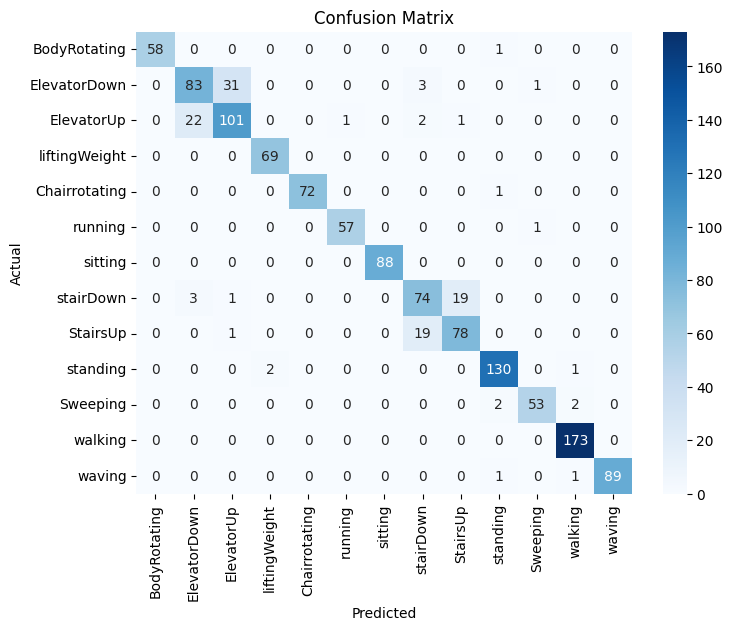

In [9]:
# Compute confusion matrix
confusion = confusion_matrix( y_test_encoded, y_pred_xgb)

class_labels = ['BodyRotating','ElevatorDown','ElevatorUp','liftingWeight','Chairrotating','running', 'sitting','stairDown','StairsUp', 'standing', 'Sweeping','walking', 'waving' ] 

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=200, random_state=42)
scores = cross_val_score(model, X, y, cv=5)

print("Cross-validation scores: ", scores)
print("Average scores: ", np.mean(scores))


Cross-validation scores:  [0.90096618 0.79685611 0.82708585 0.81378476 0.85852479]
Average scores:  0.8394435390124366


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Model Training
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    max_depth=20,      # Maximum depth of trees
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, rf_model.predict(X_test))


#Evaluation
print(f"Random Forest Accuracy: {accuracy*100:.2f}%")
print(classification_report(y_test, rf_model.predict(X_test)))




Random Forest Accuracy: 90.81%
                   precision    recall  f1-score   support

     bodyrotating       1.00      1.00      1.00        49
     elevatordown       0.78      0.71      0.74       123
       elevatorup       0.70      0.78      0.74       115
        liftingwt       1.00      1.00      1.00        74
         rotating       1.00      1.00      1.00        79
          running       1.00      0.98      0.99        55
          sitting       1.00      0.99      0.99        85
stairdown/gravity       0.82      0.76      0.79        96
  stairup/gravity       0.74      0.79      0.77        85
         standing       0.97      0.99      0.98       131
         sweeping       0.98      0.87      0.92        60
          walking       0.97      1.00      0.98       196
           waving       1.00      0.99      0.99        93

         accuracy                           0.91      1241
        macro avg       0.92      0.91      0.92      1241
     weighted avg      

In [13]:
y_test.value_counts()

activity
walking              196
standing             131
elevatordown         123
elevatorup           115
stairdown/gravity     96
waving                93
stairup/gravity       85
sitting               85
rotating              79
liftingwt             74
sweeping              60
running               55
bodyrotating          49
Name: count, dtype: int64

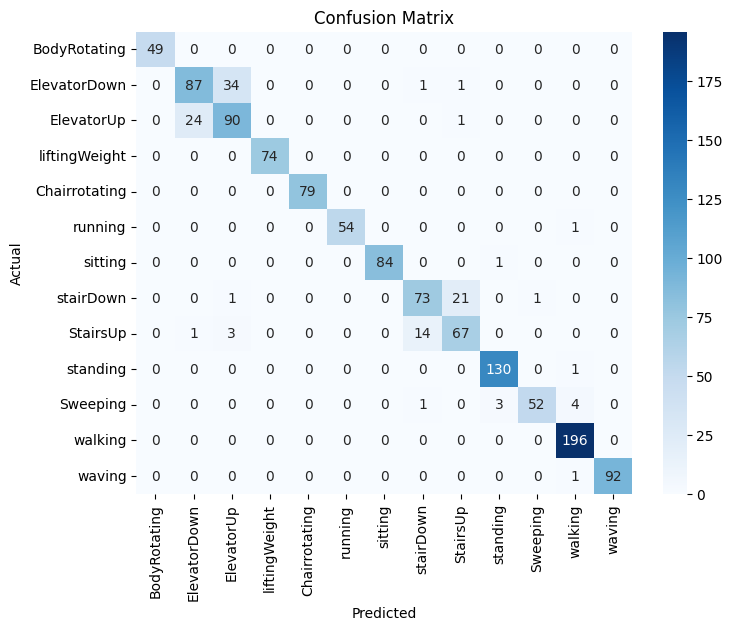

In [14]:
# Compute confusion matrix
confusion = confusion_matrix( y_test, y_pred)

class_labels = ['BodyRotating','ElevatorDown','ElevatorUp','liftingWeight','Chairrotating','running', 'sitting','stairDown','StairsUp', 'standing', 'Sweeping','walking', 'waving' ] 

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [15]:
from joblib import dump


model_filename = 'trained_model.joblib'
dump(rf_model, model_filename)


['trained_model.joblib']